# Setting up Gpu

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


# Imports

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/dev/null'
import warnings
warnings.filterwarnings("ignore", message="No artists with labels found to put in legend.") 
warnings.filterwarnings("ignore", category=FutureWarning)
import cv2
import os
import pathlib
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_gan as tfgan
from tensorflow.keras.applications import VGG16
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.linalg import sqrtm
SEED = 36
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
tf.__version__

'2.13.0'

# Loading Data

In [4]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [5]:
readDatasetObject = ReadDataset('/tf/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [6]:
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


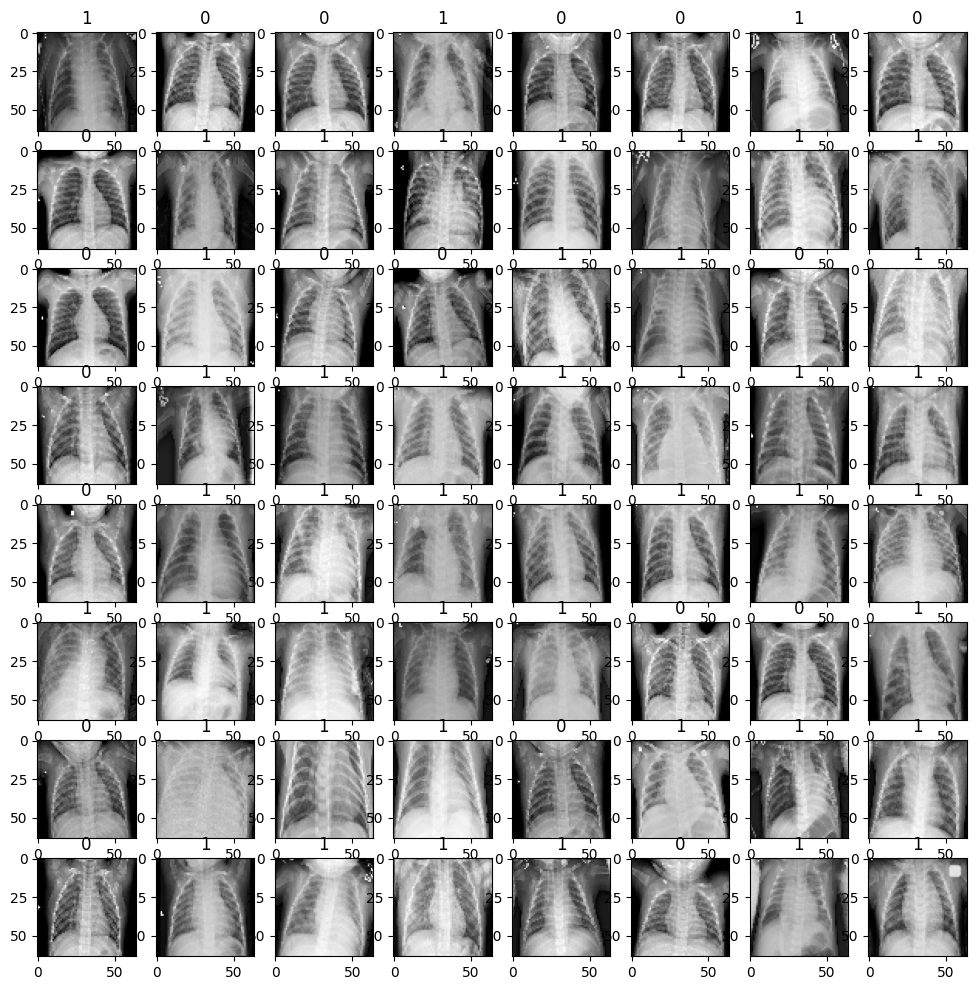

In [7]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]], cmap='gray')
    plt.title(labels[indexs[i]])
plt.legend()

# Defining the GAN module

In [8]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size, label_smoothing=0.9):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        self.label_smoothing = label_smoothing

    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()


    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(2048)(x)
        x = layers.Dense(8*8*filters[0], kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = layers.LayerNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding, strides=strides)(x)
        x = Conv2DTranspose(1, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels], outputs=x, name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding, strides=strides,
                      kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs, outputs=[outputs, labelsOutput], name='discriminator')

    def build(self):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2,))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss=['mse', 'binary_crossentropy'],
                 optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta, weight_decay=self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput], outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta*0.5, weight_decay=self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN

    def save_model_weights(self, G, D, GAN, epoch):
        G.save_weights(f'generator_weights_epoch_{epoch}.h5')
        D.save_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.save_weights(f'gan_weights_epoch_{epoch}.h5')

    def load_model_weights(self, G, D, GAN, epoch):
        G.load_weights(f'generator_weights_epoch_{epoch}.h5')
        D.load_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.load_weights(f'gan_weights_epoch_{epoch}.h5')

    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size,))*self.label_smoothing
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)), num_classes=2)
            fakeImages = G.predict([noize, fakeLabels], verbose=0)
            fakeTag = tf.zeros(shape=(self.batch_size,))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 10000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
                self.samples(G, noize, fakeLabels)
                # Save model weights
                self.save_model_weights(G, D, GAN, epoch)

# Instantiating the model

In [9]:
acgan = Acgan(eta = 0.0002, batch_size = 32, epochs = 62000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 1), kernel_size = 5)

In [10]:
acgan.data(images, labels)

In [11]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           832       ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_4[0][0]']       
                                                                                      

# Training

In [12]:
#acgan.trainAlgorithm(G, D, GAN)

In [13]:
last_epoch = 60000
acgan.load_model_weights(G, D, GAN, last_epoch)

In [14]:
#G.save('/tf/Model/generator.h5')

In [15]:
#G = tf.keras.models.load_model('/tf/Model/generator.h5')

# Evaluation

In [16]:
def calculate_fid(real_images, generated_images):
    import numpy as np
    from scipy.linalg import sqrtm
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    import tensorflow as tf

    # Resize images to 299x299
    real_images_resized = tf.image.resize(real_images, (299, 299), method='bicubic')
    generated_images_resized = tf.image.resize(generated_images, (299, 299), method='bicubic')

    # Load InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Get activations
    act_real = model.predict(real_images_resized)
    act_gen = model.predict(generated_images_resized)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen) ** 2)
    covmean = sqrtm(sigma_real.dot(sigma_gen))

    # Numerical error handling
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

In [17]:
def calculate_kid(real_images, generated_images):
    import numpy as np
    from scipy.linalg import sqrtm
    from sklearn.metrics.pairwise import polynomial_kernel
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    import tensorflow as tf

    # Resize images to 299x299 pixels
    real_images_resized = tf.image.resize(real_images, (299, 299), method='bicubic')
    generated_images_resized = tf.image.resize(generated_images, (299, 299), method='bicubic')


    # Load pre-trained InceptionV3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Get the activations
    act_real = inception_model.predict(real_images_resized)
    act_gen = inception_model.predict(generated_images_resized)

    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real, degree=3, gamma=None, coef0=1)
    kernel_gen = polynomial_kernel(act_gen, degree=3, gamma=None, coef0=1)
    kernel_cross = polynomial_kernel(act_real, act_gen, degree=3, gamma=None, coef0=1)

    m = len(act_real)
    n = len(act_gen)

    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid


In [18]:
def convert_grayscale_to_rgb(images):
    # Convert numpy array to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images)
    # Convert grayscale images to RGB
    return tf.image.grayscale_to_rgb(images_tensor)


In [19]:
def normalize_tensor(tensor):
    # Find the minimum and maximum values of the tensor
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    
    # Normalize the tensor to [0, 1]
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    
    # Scale the normalized tensor to [-1, 1]
    normalized_tensor_neg_one_to_one = (normalized_tensor * 2) - 1
    
    return normalized_tensor_neg_one_to_one


In [20]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [21]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [22]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14959, 15041]))

In [23]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 9s 9ms/step


(30000, 64, 64, 1)

In [24]:
images_normalized = normalize_tensor(images)
imagesGeneration_normalized = normalize_tensor(imagesGeneration)

# Convert grayscale images to RGB
real_images_rgb = convert_grayscale_to_rgb(images_normalized)
generated_images_rgb = convert_grayscale_to_rgb(imagesGeneration_normalized)

# Calculate FID and KID scores
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
kid_score = calculate_kid(real_images_rgb, generated_images_rgb)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')


938/938 [==============================] - 39s 41ms/step
FID Score: 114.54199634432547
KID Score: 0.1378783539205255


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


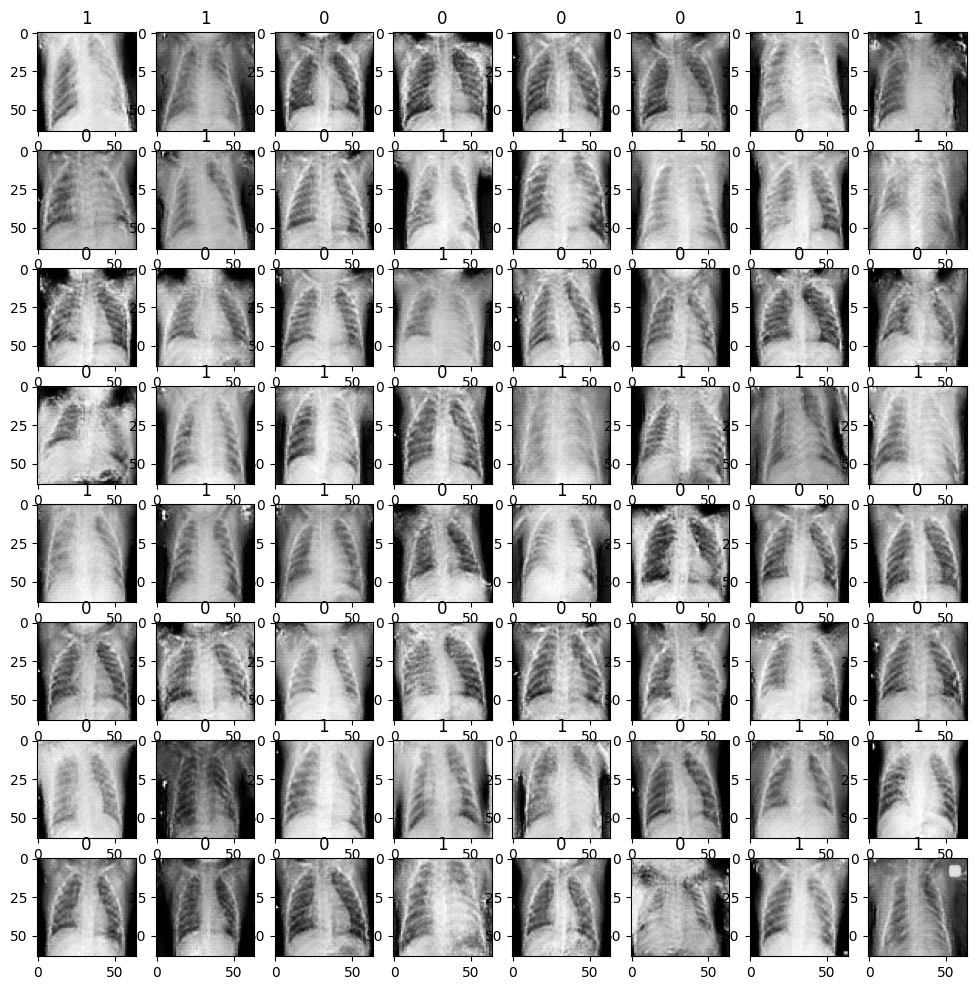

In [25]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i],cmap='gray')
    plt.title(t[i])
plt.legend()

In [26]:
# Using VGG16 with pre-trained weights for fine-tuning
basemodel = tf.keras.applications.VGG16(weights=None, input_shape=(64, 64, 1),
                                        pooling='max', include_top=False)
# Model architecture
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification
m = tf.keras.models.Model(inputs=basemodel.input, outputs=x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [27]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 20s 34ms/step - loss: 0.1983 - val_loss: 0.5158
Epoch 2/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0607 - val_loss: 0.0489
Epoch 3/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0465 - val_loss: 0.0217
Epoch 4/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0354 - val_loss: 0.0222
Epoch 5/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0312 - val_loss: 0.0236
Epoch 6/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0266 - val_loss: 0.0162
Epoch 7/60
375/375 [==============================] - 12s 31ms/step - loss: 0.0230 - val_loss: 0.0117
Epoch 8/60
375/375 [==============================] - 11s 31ms/step - loss: 0.0199 - val_loss: 0.0095
Epoch 9/60
375/375 [==============================] - 11s 31ms/step - loss: 0.0196 - val_loss: 0.0096
Epoch 10/60
375/375 [==============================] - 11s 31ms/step - loss: 0.017

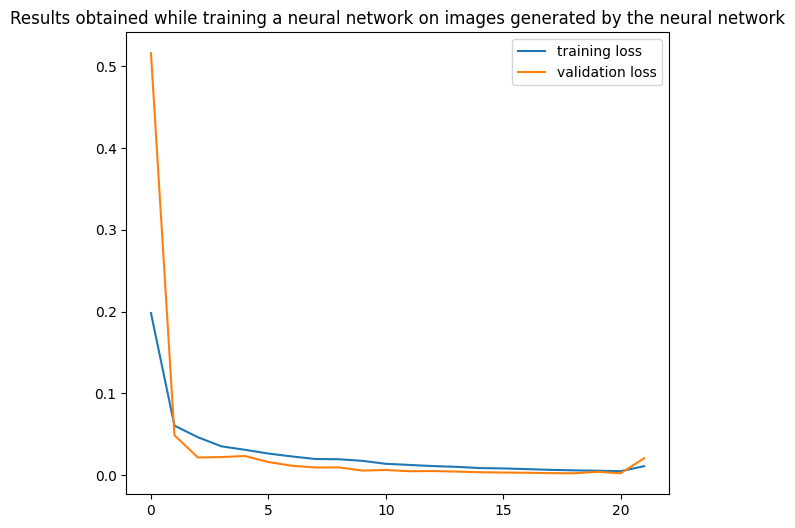

In [28]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [29]:
readDatasetObject = ReadDataset('/tf/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images_test, labels_test = readDatasetObject.readImages()

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
def calculate_metrics(model, images, labels):
    loss = model.evaluate(images, labels, verbose=0)  
    y_pred = tf.squeeze(model.predict(images))
    y_pred = y_pred >= 0.5
    y_pred = np.array(y_pred, dtype='int32')
    labels = np.array(labels, dtype='int32')
    acc = accuracy_score(y_pred, labels) * 100
    f1 = f1_score(y_pred, labels) * 100
    recall = recall_score(y_pred, labels) * 100
    precision = precision_score(y_pred, labels) * 100
    cm = confusion_matrix(y_pred, labels)
    cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
    sns.heatmap(cmObject, annot = True, cmap="Blues")
    return {
        'accuracy': acc,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'confusion_matrix': cm
    }


20/20 [==============================] - 0s 6ms/step
1:1 Ratio -> Accuracy: 85.10%, F1 Score: 88.21%, Recall: 87.22%, Precision: 89.23%


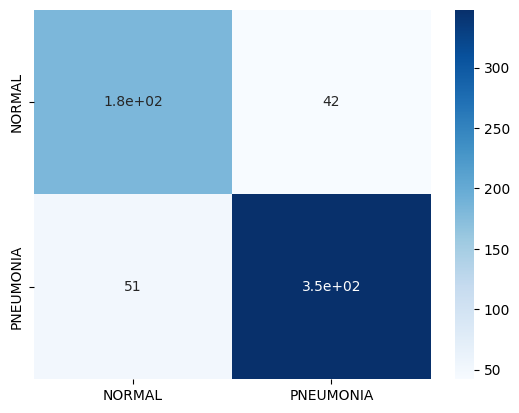

In [31]:
metrics = calculate_metrics(m, images_test, labels_test)
print(f"1:1 Ratio -> Accuracy: {metrics['accuracy']:.2f}%, F1 Score: {metrics['f1_score']:.2f}%, "
      f"Recall: {metrics['recall']:.2f}%, Precision: {metrics['precision']:.2f}%")

In [32]:
print(metrics['confusion_matrix'])

[[183  42]
 [ 51 348]]
